# Analyze Munich bicycle data
Idea to visualize the data from: https://jakevdp.github.io/blog/2017/03/03/reproducible-data-analysis-in-jupyter/

## Content
* [Load data](#Load-data-(15-minute-resolution)
* [Counting locations](#Counting-locations)
* [Count bikes](#Count-bikes)
* [Visualize time of day](#Visualize-time-of-day)
* [Cluster time of day characteristics](#Cluster-time-of-day-characteristics)
* [Find weekday outliers](#Find-weekday-outliers)

#### Imports

In [1]:
%matplotlib inline

from collections import Counter
import requests

import pandas as pd
import numpy as np
from sklearn.decomposition import PCA
from sklearn.mixture import GaussianMixture
import matplotlib.pyplot as plt
plt.style.use('seaborn')

In [2]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:80% !important; }</style>"))

In [3]:
pd.set_option('display.max_rows', 500)
Y_LABEL = '# of bikes'

## Load data (15 minute resolution)
* Data is licensed with: "Datenquelle: dl-de/by-2-0: Landeshauptstadt München – Kommunalreferat – GeodatenService – www.geodatenservice-muenchen.de"
* Data describes how many people are driving over the counting point in which direction

In [4]:
data = pd.read_csv('data/15mins.csv', sep=';', parse_dates=[['datum', 'uhrzeit_start']])
data.index = data.datum_uhrzeit_start.values
data.drop(['datum_uhrzeit_start', 'uhrzeit_ende'], inplace=True, axis=1)
data.rename({'richtung_1': 'direction_1', 'richtung_2': 'direction_2', 'gesamt': 'total'}, axis=1, inplace=True)

data['2018-05-05 15:00':'2018-05-05 15:45']

zaehlstelle  direction_1  direction_2  total
2018-05-05 15:00:00      Arnulf           29            1     30
2018-05-05 15:15:00      Arnulf           17            0     17
2018-05-05 15:30:00      Arnulf           26            0     26
2018-05-05 15:45:00      Arnulf           16            0     16
2018-05-05 15:00:00    Kreuther            0            3      3
2018-05-05 15:15:00    Kreuther            4            5      9
2018-05-05 15:30:00    Kreuther            2            8     10
2018-05-05 15:45:00    Kreuther            2            2      4
2018-05-05 15:00:00     Olympia           36           28     64
2018-05-05 15:15:00     Olympia           37           49     86
2018-05-05 15:30:00     Olympia           30           43     73
2018-05-05 15:45:00     Olympia           42           46     88
2018-05-05 15:00:00      Hirsch           14            9     23
2018-05-05 15:15:00      Hirsch           22            8     30
2018-05-05 15:30:00      Hirsch            6           12     18
2018-05-05 15:45:00      Hirsch           16            9     25
2018-05-05 15:00:00  Margareten           30           34     64
2018-05-05 15:15:00  Margareten           28           27     55
2018-05-05 15:30:00  Margareten           29           29     58
2018-05-05 15:45:00  Margareten           39           23     62
2018-05-05 15:00:00     Erhardt           71          102    173
2018-05-05 15:15:00     Erhardt           71           92    163
2018-05-05 15:30:00     Erhardt           80           78    158
2018-05-05 15:45:00     Erhardt           76           68    144

## Counting locations

In [5]:
zaehlstellen = np.unique(data.zaehlstelle)
print(zaehlstellen)

['Arnulf' 'Erhardt' 'Hirsch' 'Kreuther' 'Margareten' 'Olympia']


In [6]:
%%HTML
<iframe width="800" height="600" src="https://www.opengov-muenchen.de/dataset/raddauerzaehlstellen-muenchen/resource/211e882d-fadd-468a-bf8a-0014ae65a393/view/11a47d6c-0bc1-4bfa-93ea-126089b59c3d" frameBorder="0"></iframe>

## Count bikes
### Get number of bikes for each counting location (15 min raw data,  1 hour filtering, 1 day filtering, 1 week filtering)

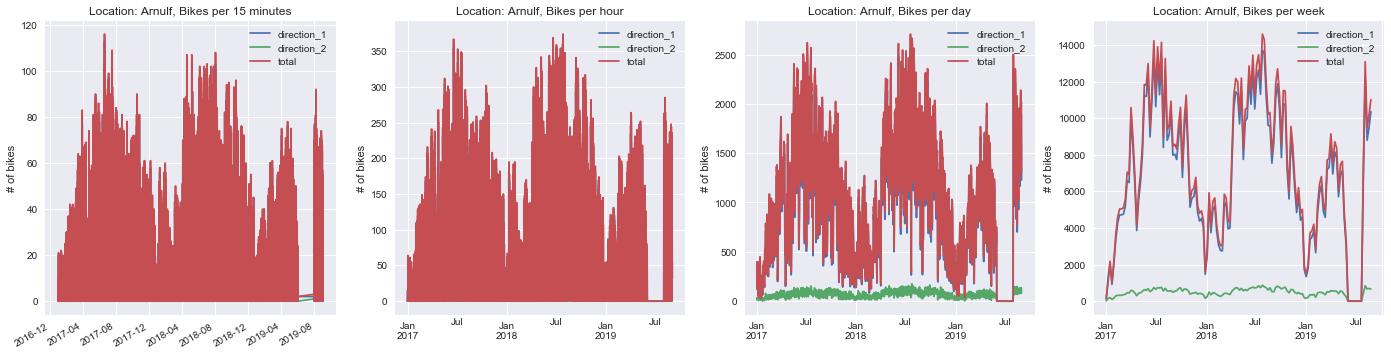

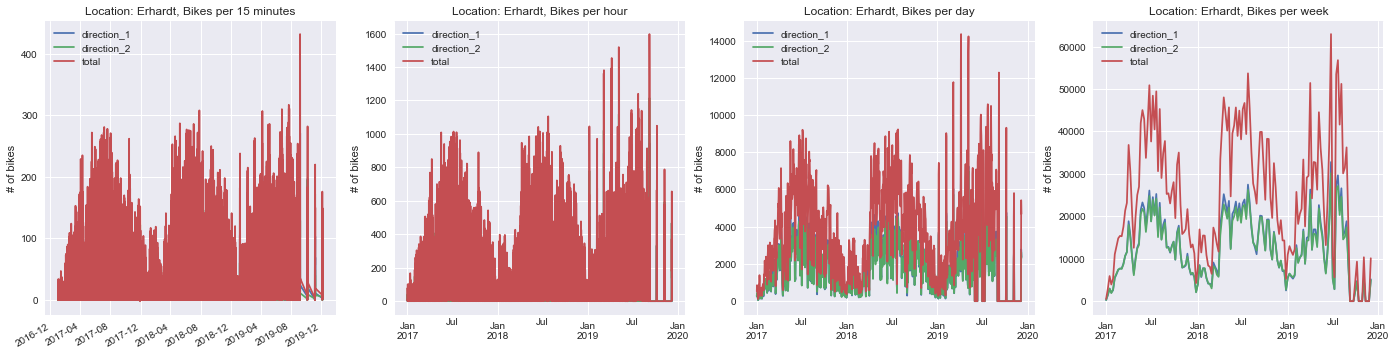

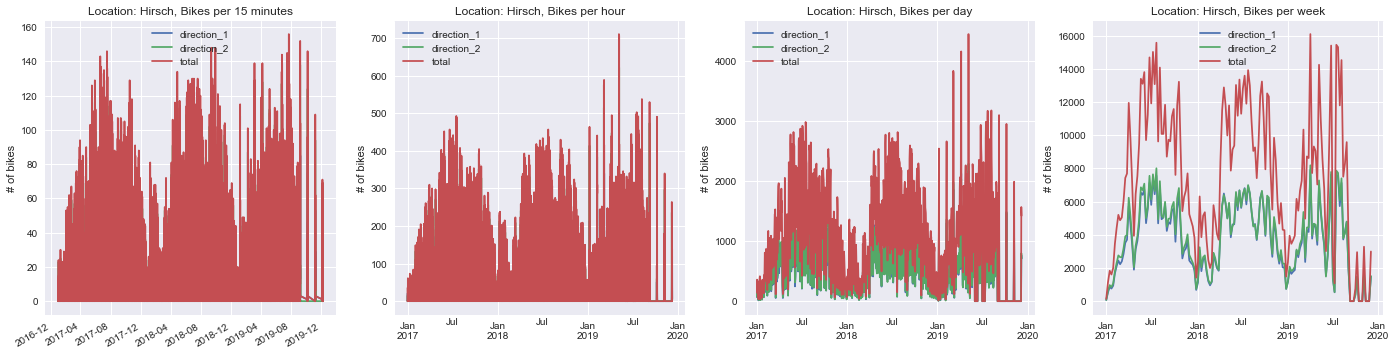

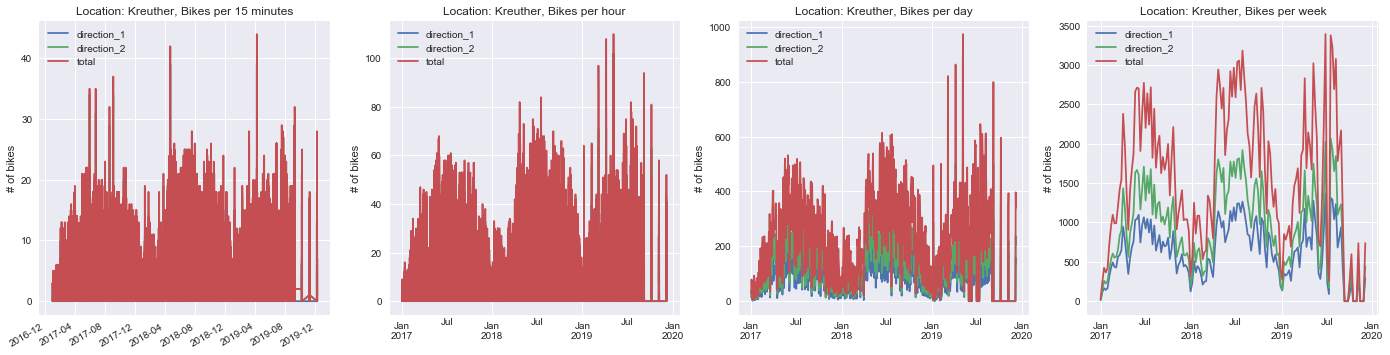

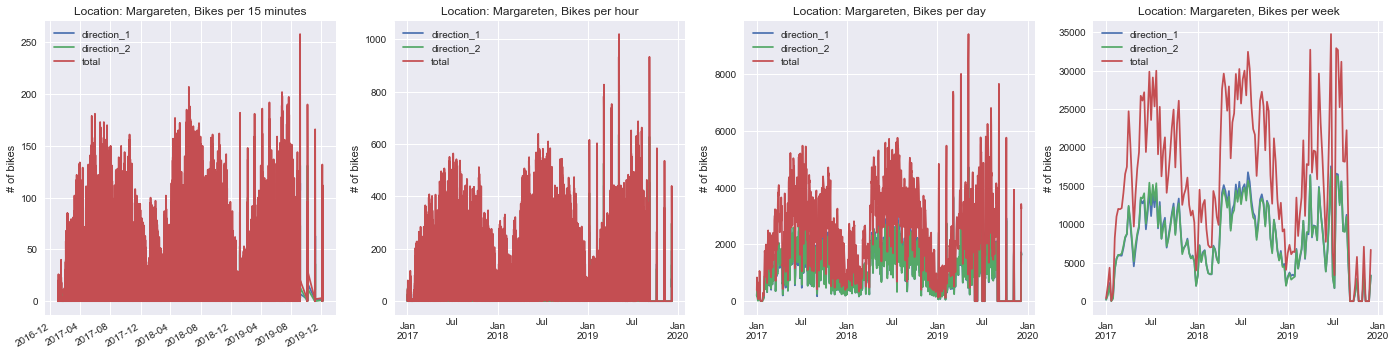

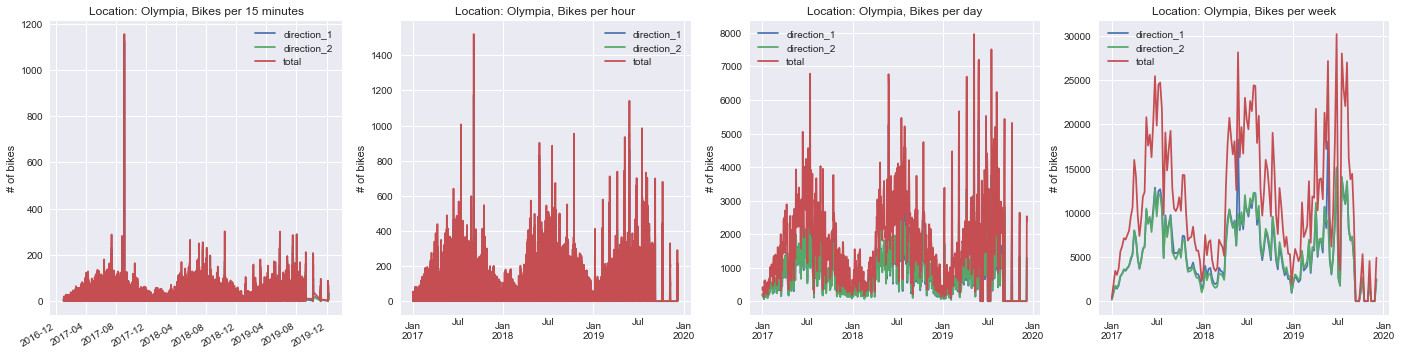

In [7]:
for zaehlstelle in zaehlstellen:
    df = data[data.zaehlstelle == zaehlstelle]
    df_hourly = df.resample('H').sum()
    df_daily = df.resample('D').sum()
    df_weekly = df.resample('W').sum()
    title = f'Location: {zaehlstelle}, Bikes per'
    fig, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(24, 6))
    df.plot(title=title +' 15 minutes', ax=ax1)
    df_hourly.plot(title=title +' hour', ax=ax2)
    df_daily.plot(title=title + ' day', ax=ax3)
    df_weekly.plot(title=title + ' week', ax=ax4)
    ax1.set_ylabel(Y_LABEL)
    ax2.set_ylabel(Y_LABEL)
    ax3.set_ylabel(Y_LABEL)
    ax4.set_ylabel(Y_LABEL)
    
    #eval_high_counts = df_daily
    #arg_max = eval_high_counts['total'].values.argmax()
    #print(f'Maximal number of counted bikes for {zaehlstelle}:\n{eval_high_counts.iloc[arg_max]}\n')

### Explainable high bicycle counts
* 2017-09-03: https://www.olympiapark.de/de/veranstaltungen-tickets/sportevents/detailansicht/event/5294/muenchner_ringparade/

* 2019-04-07: https://www.adfc-muenchen.de/sternfahrt/

* 2019-05-07: ???

* 2019-09-07: https://www.muenchen.de/aktuell/2019-07/warnstreik-mvg-ubahn-tram.html


## Visualize time of day
### With mean number of bikes
__General:__
* For all location but "Arnulf" and "Kreuther" the number of counted bikes in one direction equals the number of counted bikes in the other direction.
* For location "Kreuther" the distribution in one direction vs the other direction is 100/150 (For every 100 bikes in one direction 150 bikes go in the other direction)
* For location "Arnulf" only traffic on one side of the street is counted.
* For location "Arnulf" approximately 74 or about 6.5% bikers per day are driving on the wrong side of the street

__Time explanation:__
* All counting location have a peak at around 8:30 and 18:00 which equals to working day of approximately 8 hours with 1 hour break
* These peaks are the times the munich people commute to work
* The first peak is a lot sharper then the second peak. This indicates that for the second peak there are additional effects than only comuting to work (see explanation later)

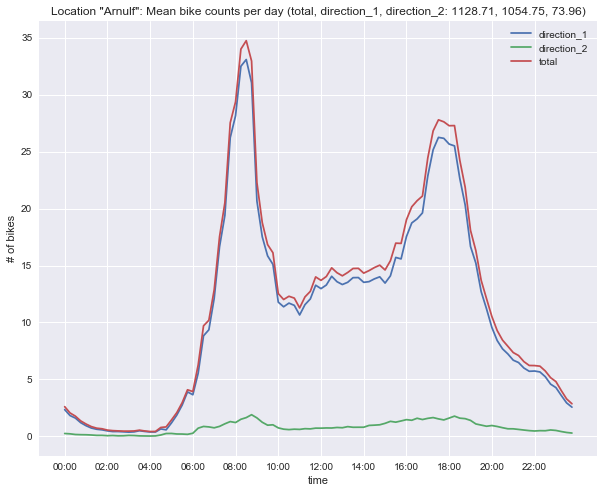

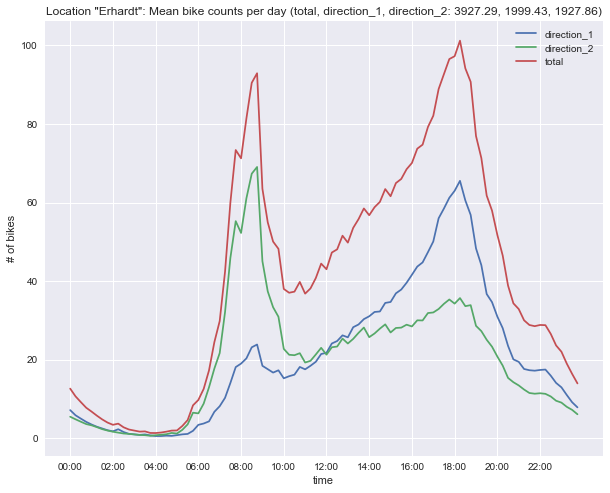

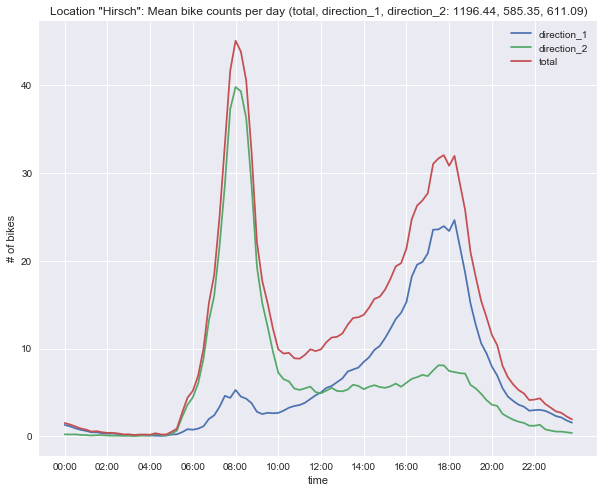

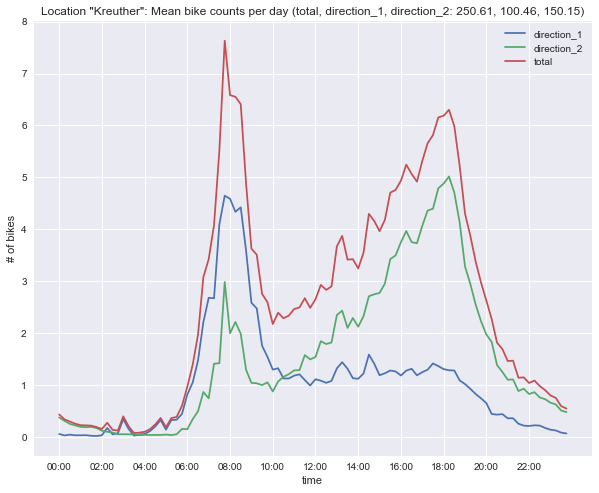

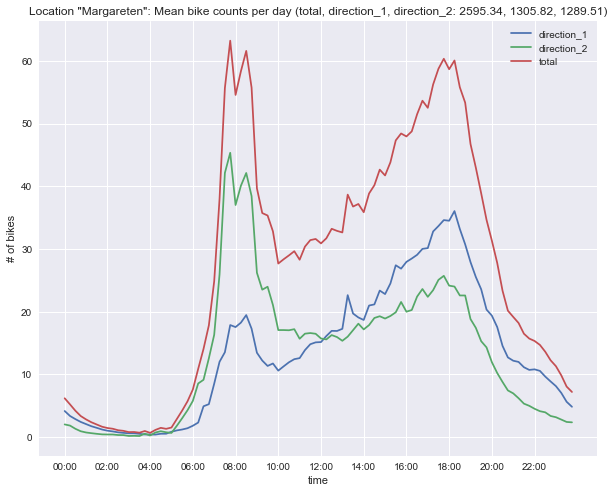

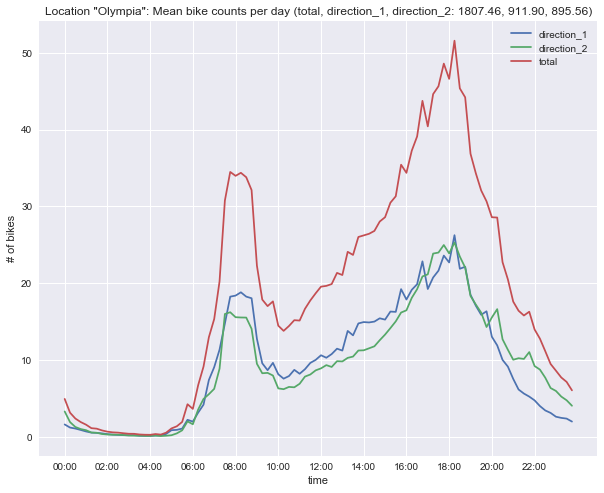

In [8]:
for zaehlstelle in zaehlstellen:
    df = data[data.zaehlstelle == zaehlstelle]
    df_grouped = df.groupby(df.index.time).mean()
    
    total_mean = np.sum(df_grouped['total'])
    direction_1_mean = np.sum(df_grouped['direction_1'])
    direction_2_mean = np.sum(df_grouped['direction_2'])

    title = f'Location "{zaehlstelle}": Mean bike counts per day (total, direction_1, direction_2: {total_mean:.2f}, {direction_1_mean:.2f}, {direction_2_mean:.2f})'
    ax = df_grouped.plot(title=title, figsize=(10, 8))
    ax.set_xticks(df_grouped.index[::8])
    ax.set_ylabel(Y_LABEL)
    
    # display(df_grouped.sort_values('total', ascending=False)[:10])

### Plot bicycle counts (per 15 minutes) for each day and each counting location:
__General:__
* The most bikes are counted at location "Erhardt", the least for "Kreuther"
* Olympia has the most unstable graphs (perhas because of day trips)

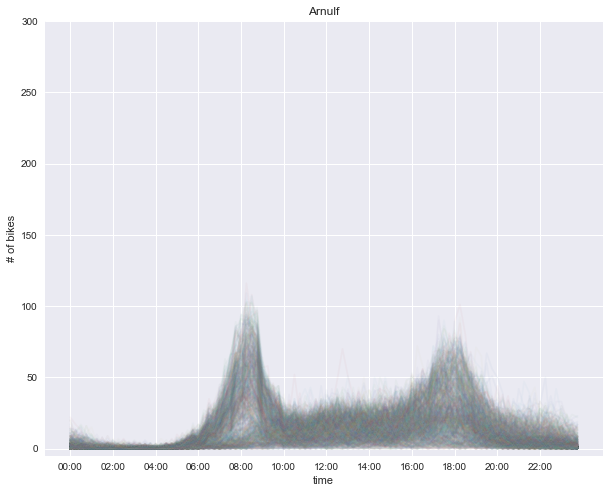

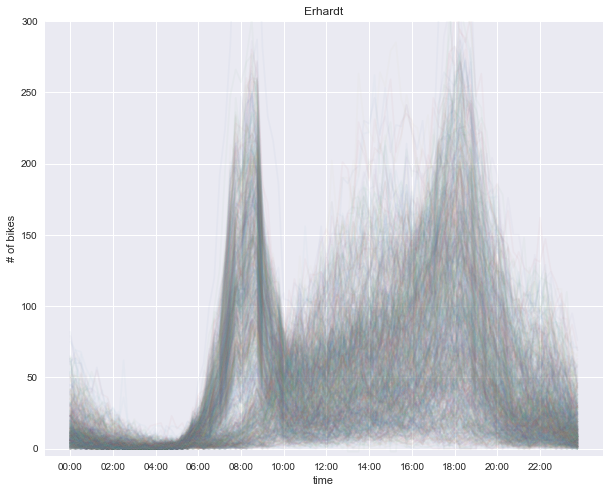

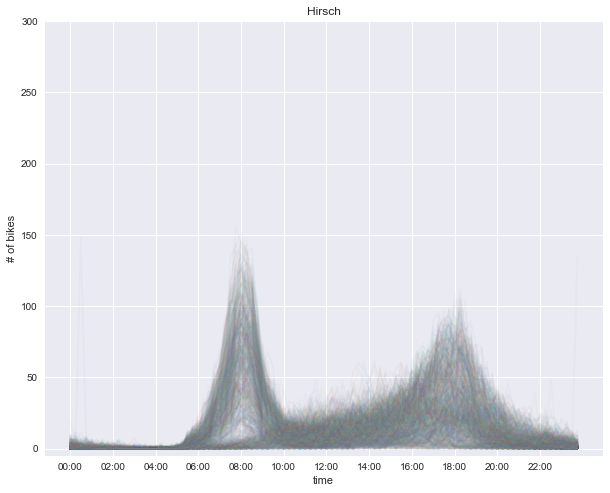

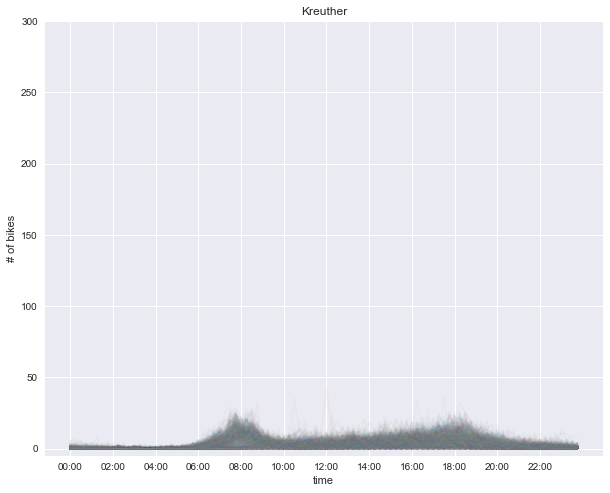

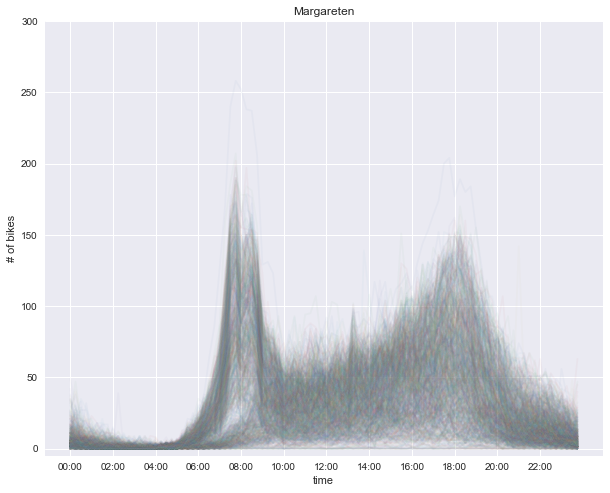

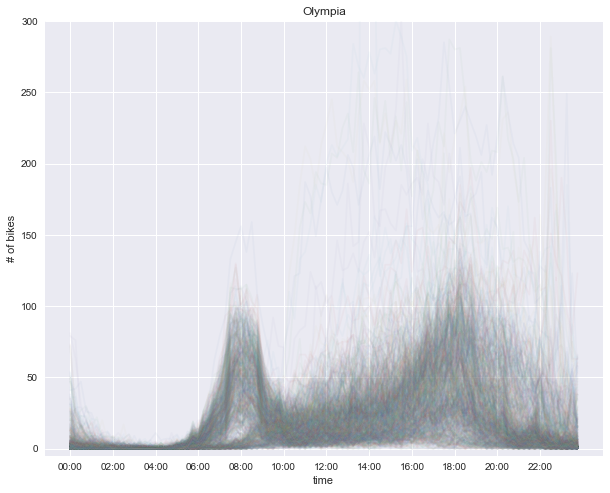

In [9]:
for zaehlstelle in zaehlstellen:
    df = data[data.zaehlstelle == zaehlstelle]
    df = df.drop(['zaehlstelle'], axis=1)
    pivoted = df.pivot_table('total', index=df.index.time, columns=df.index.date)
    ax = pivoted.plot(legend=False, alpha=0.04, title=zaehlstelle, ylim=[-5, 300], figsize=(10, 8))
    ax.set_xticks(pivoted.index[::8])
    ax.set_ylabel(Y_LABEL)

## Cluster time of day characteristics
### Split data to two seperate clusters with characteristic bike counts over time of day
* Clustering works for most locations
* Olympia is more a day trip location, so clustering works not as god for this location
* The clustering splits the data into weekdays and weekend

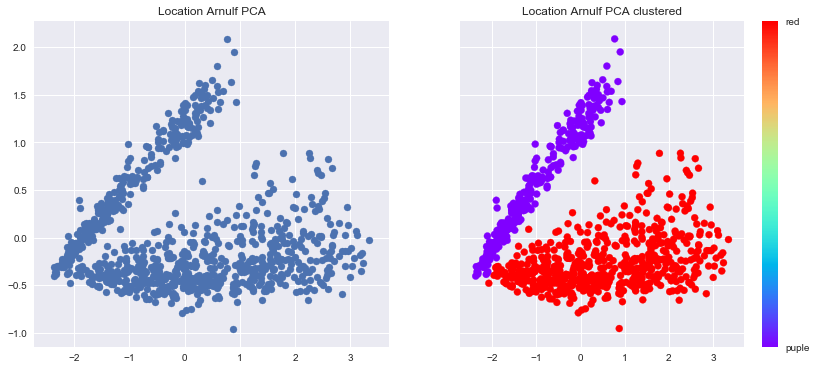

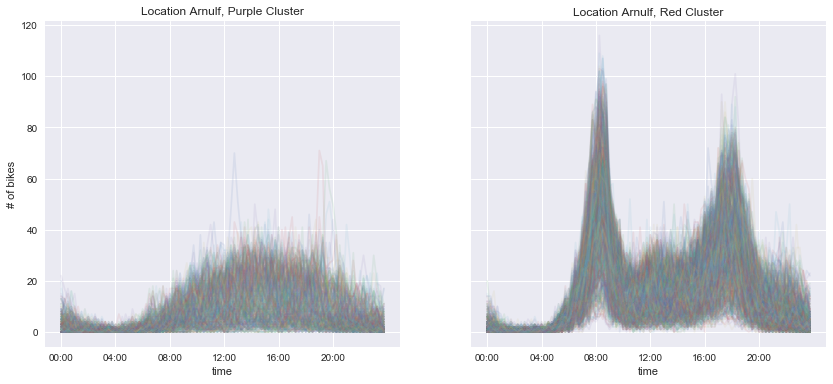

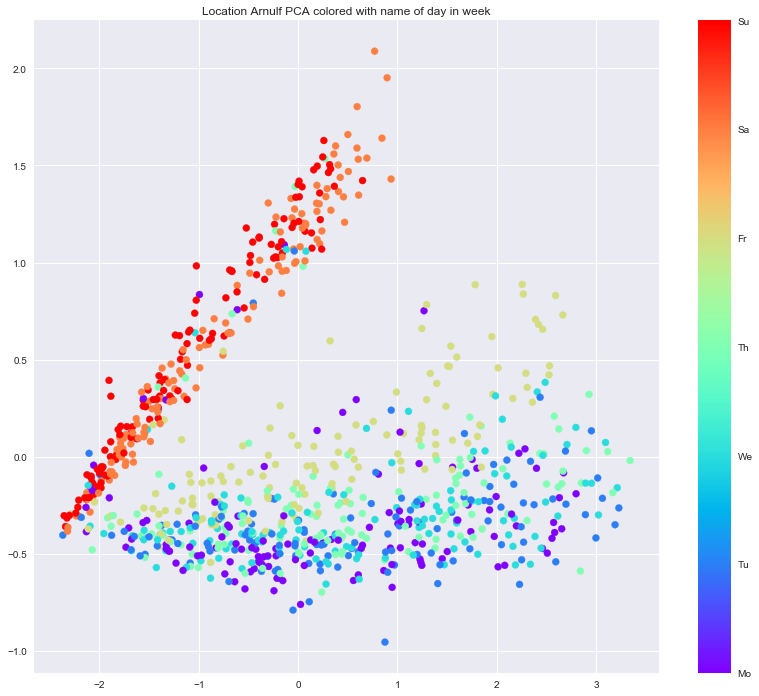

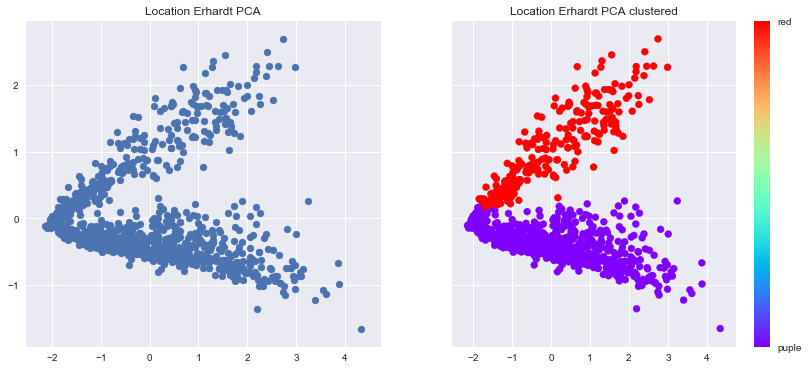

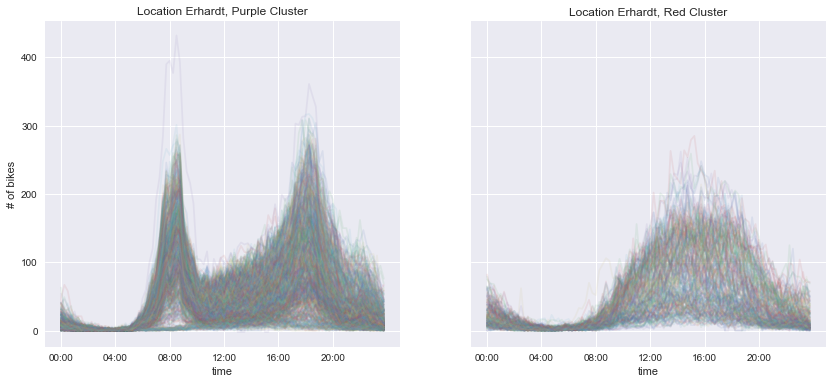

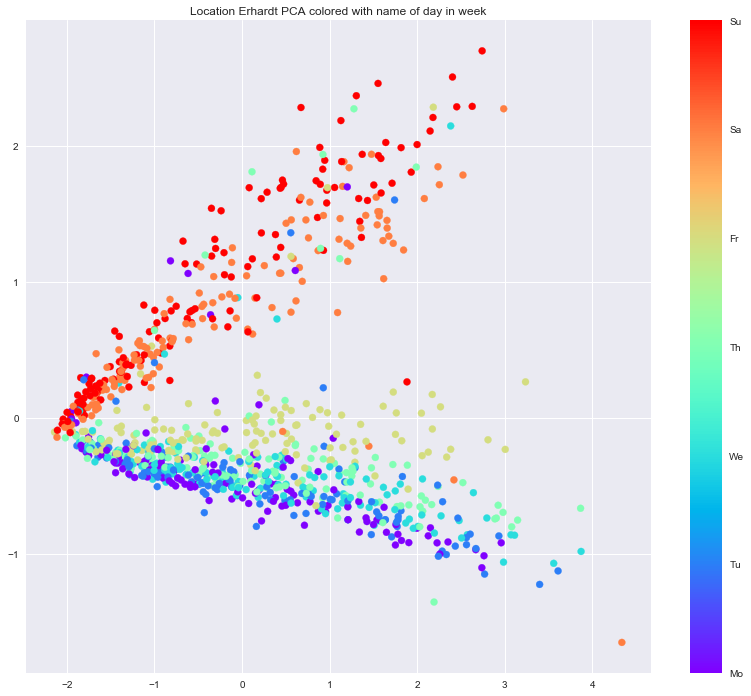

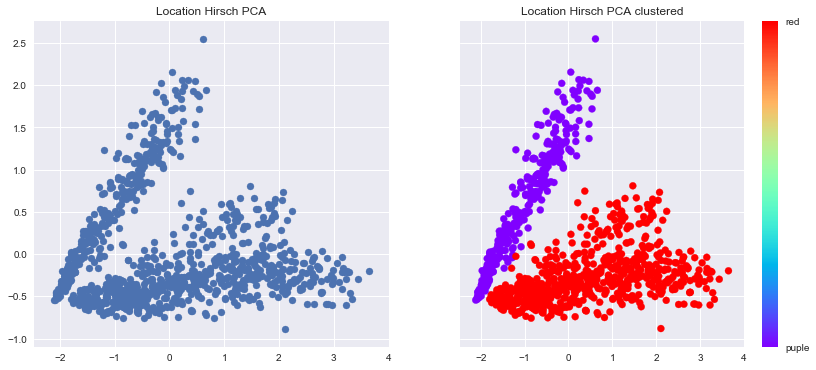

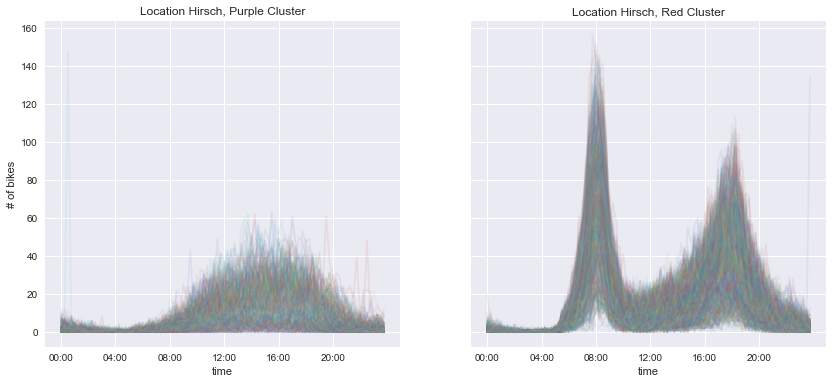

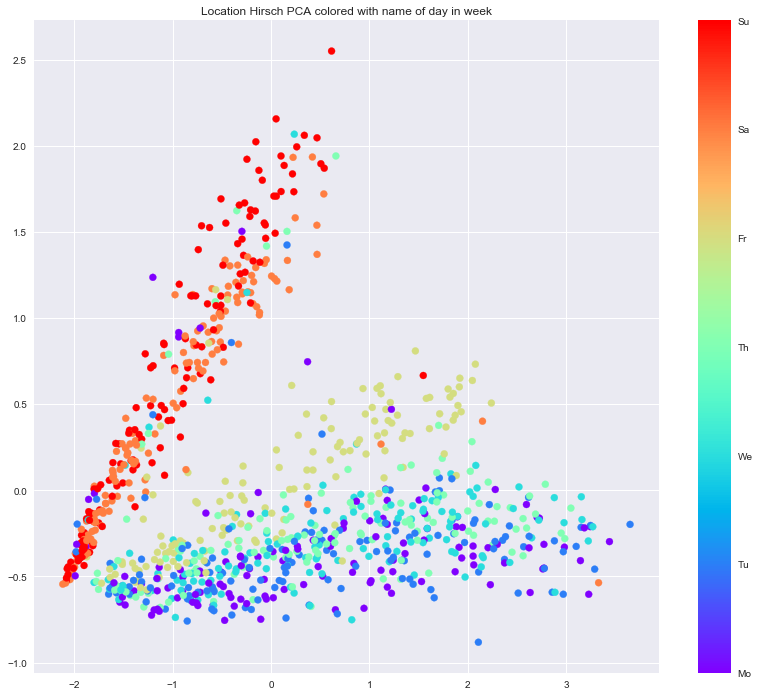

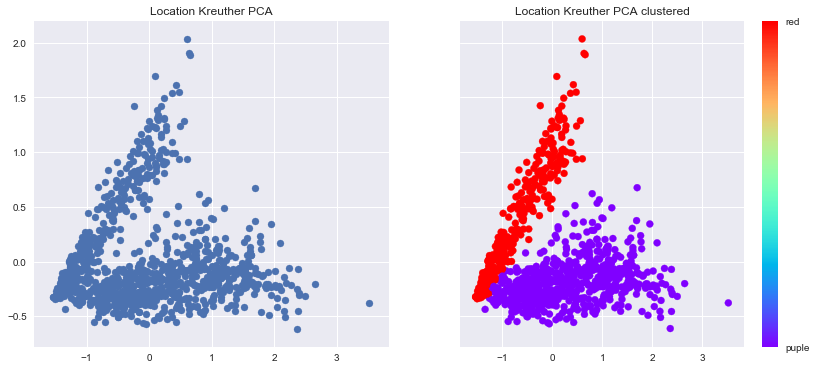

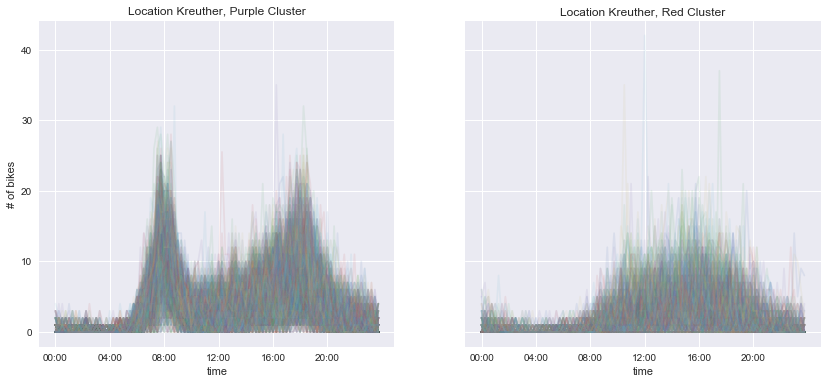

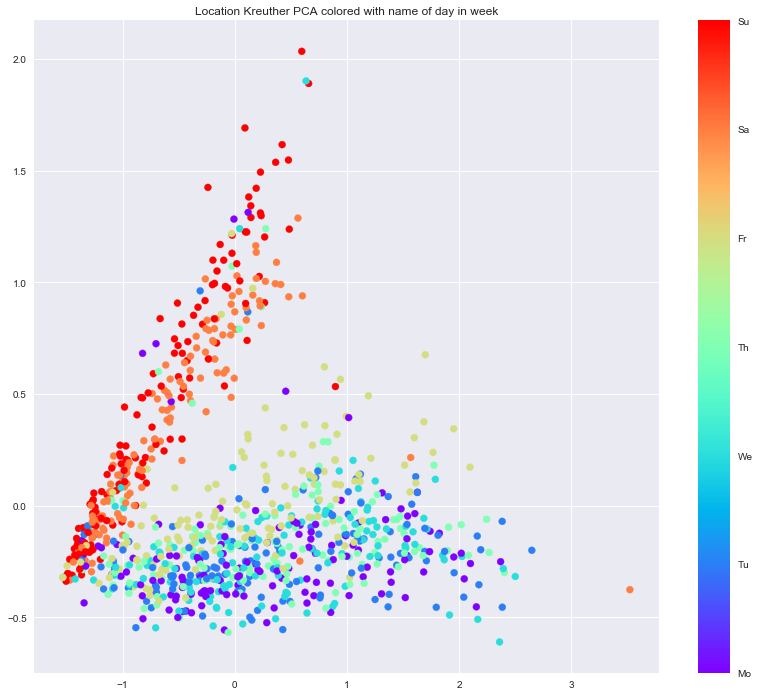

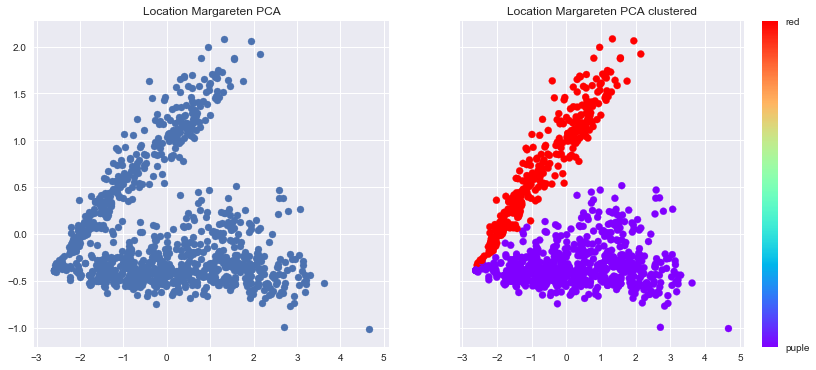

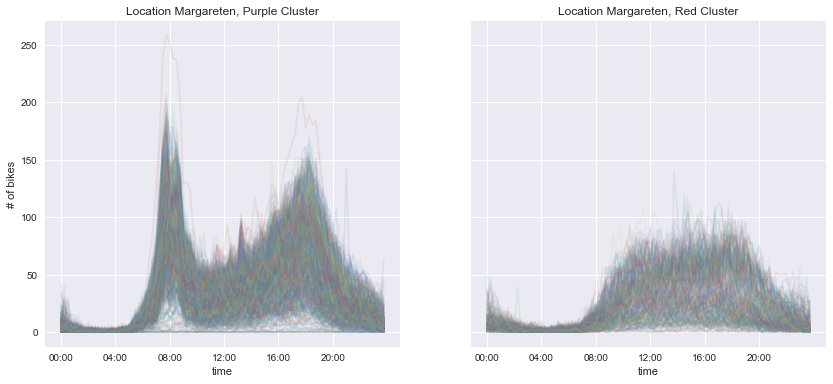

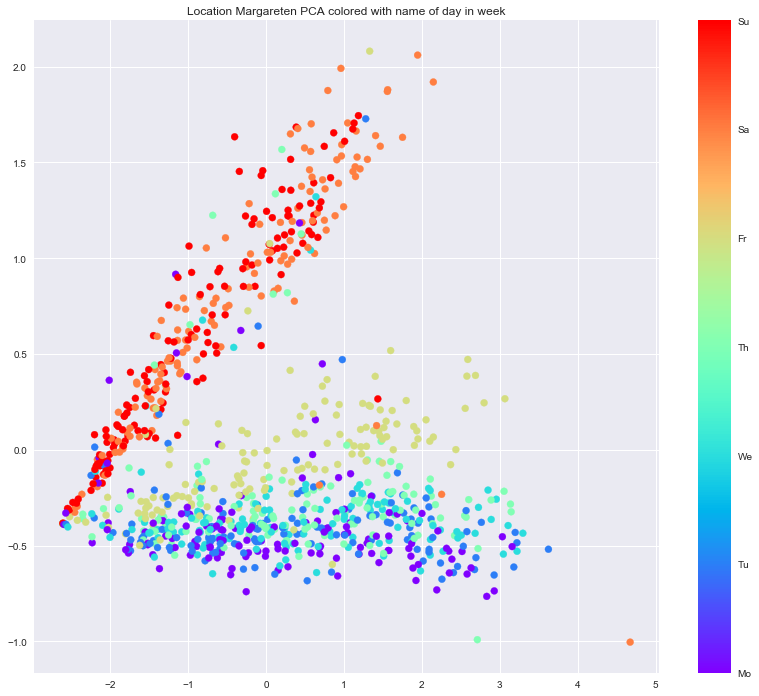

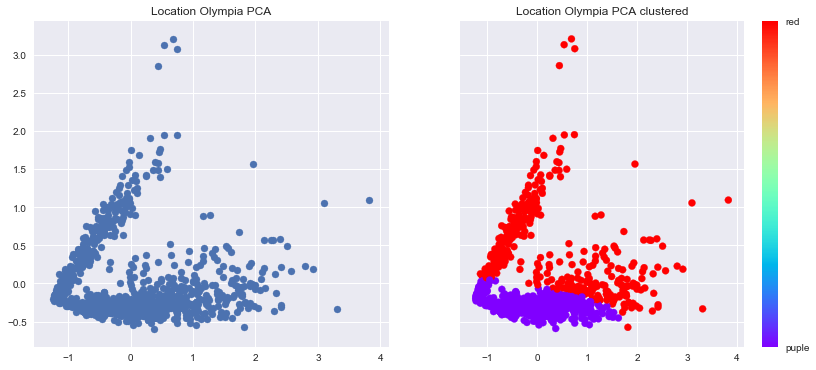

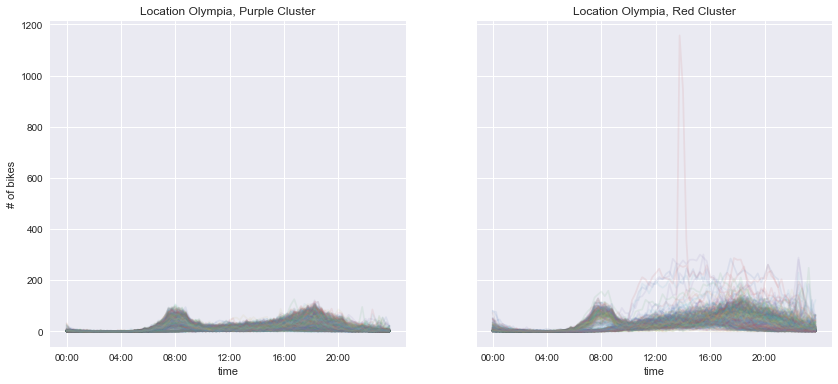

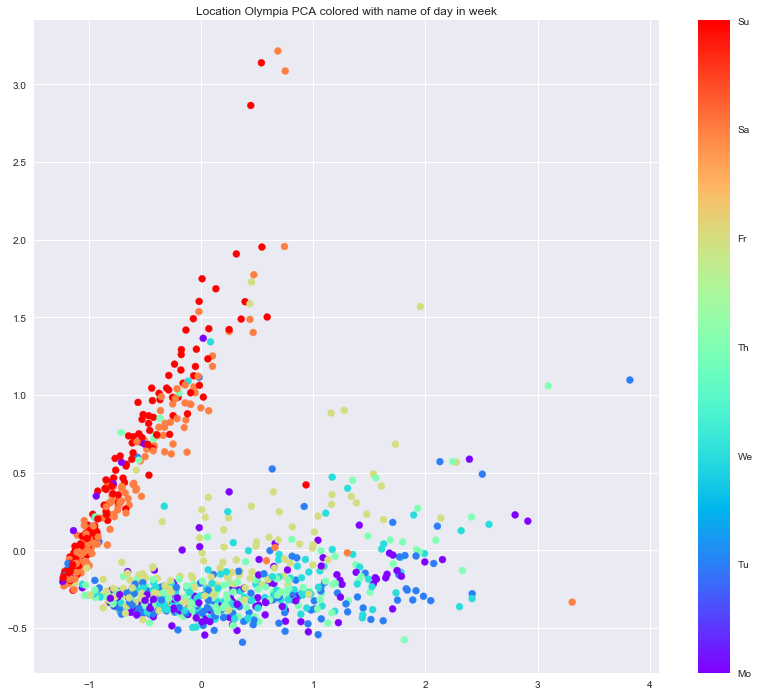

In [10]:
models = {}
labels = {}
outliers = {}
for zaehlstelle in zaehlstellen:
    df = data[data.zaehlstelle == zaehlstelle]
    df = df.drop(['zaehlstelle'], axis=1)
    pivoted = df.pivot_table('total', index=df.index.time, columns=df.index.date)
    X = pivoted.fillna(0).T.values
    X = X / np.max(X, axis=0)
    XX = PCA(2, svd_solver='full').fit_transform(X)
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharex=True, sharey=True, figsize=(14, 6))
    ax1.scatter(XX[:, 0], XX[:, 1])
    title = f'Location {zaehlstelle}'
    ax1.set_title(title + ' PCA')
    ax2.set_title(title + ' PCA clustered')

    models[zaehlstelle] = GaussianMixture(2).fit(XX)
    labels[zaehlstelle] = models[zaehlstelle].predict(XX)
    
    plt.scatter(XX[:, 0], XX[:, 1], c=labels[zaehlstelle], cmap='rainbow')
    cbar = plt.colorbar()
    cbar.set_ticks([0, 1])
    cbar.ax.set_yticklabels(['puple', 'red'])
    
    fig, (ax1, ax2) = plt.subplots(1, 2, sharey=True, figsize=(14, 6))
    pivoted.T[labels[zaehlstelle] == 0].T.plot(legend=False, alpha=0.1, ax=ax1);
    pivoted.T[labels[zaehlstelle] == 1].T.plot(legend=False, alpha=0.1, ax=ax2);
    ax1.set_title(title + ', Purple Cluster')
    ax1.set_ylabel(Y_LABEL)
    ax1.set_xticks(pivoted.index[::16])
    ax2.set_title(title + ', Red Cluster')
    ax2.set_ylabel(Y_LABEL)
    ax2.set_xticks(pivoted.index[::16])
    
    dayofweek = pd.DatetimeIndex(pivoted.columns).dayofweek
    
    plt.figure(figsize=(14, 12))
    plt.title(title + ' PCA colored with name of day in week')
    plt.scatter(XX[:, 0], XX[:, 1], c=dayofweek, cmap='rainbow')
    cbar = plt.colorbar()
    cbar.ax.set_yticklabels(['Mo', 'Tu', 'We', 'Th', 'Fr', 'Sa', 'Su'])
    
    # get outliers (weekend bahaviour but in weekday cluster)
    dates = pd.DatetimeIndex(pivoted.columns)
    counted_labels = Counter(labels[zaehlstelle])
    cmp_label = counted_labels.most_common(2)[1][0] # get second most common cluster (this should be the weekend cluster)
    outliers[zaehlstelle] = dates[(labels[zaehlstelle] == cmp_label) & (dayofweek < 5)]

## Find weekday outliers
* Outliers are defined as a weekend behaviour, but being during a weekday
### Add public holidays to data (bavaria)

In [11]:
list_of_df_outliers = [pd.DataFrame(np.ones(values.shape, dtype=int), columns=[key], index=pd.to_datetime(values)) for key, values in outliers.items() if key != 'Olympia']

# use without olympia, because clustering of weekdays ws weekend has not worked for that dataset
outliers_without_olympia = pd.concat(list_of_df_outliers, axis=1, sort=False)

In [12]:
# extract bavarian public holidays from the web
start_date = pd.to_datetime(outliers_without_olympia.index.values[0])
end_date = pd.to_datetime(outliers_without_olympia.index.values[-1])

public_holidays = pd.DataFrame()
for year in np.arange(start_date.year, end_date.year + 1):
    r = requests.get(f'https://feiertage-api.de/api/?jahr={year}&nur_land=BY')
    public_holidays_yearwise = r.json()
    public_holidays = pd.concat([public_holidays, pd.DataFrame(public_holidays_yearwise)], axis=1)
public_holidays = public_holidays.T.reset_index().set_index('datum')
public_holidays.index = pd.to_datetime(public_holidays.index)
public_holidays['dayofweek'] = public_holidays.index.day_name()
public_holidays['dayofweek_num'] = public_holidays.index.dayofweek

In [13]:
public_holidays = public_holidays[public_holidays['dayofweek_num'] < 5]  # remove all saturdays and sundays
public_holidays = public_holidays[public_holidays.index <= end_date]  # remove all future holidays

In [14]:
# merge outliers and public holidays together:
holiday_table = pd.concat([outliers_without_olympia, public_holidays], sort=True, axis=1).fillna('')

### Look at public holidays
* Public holidays as well as the time between christmas and new years eve have the same cluster as weekends
* This means weekends and public holidays have the same bike usage statistics

In [15]:
holiday_table

Arnulf Erhardt Hirsch Kreuther Margareten  \
2017-01-05                              1              
2017-01-06      1              1        1              
2017-01-09                              1              
2017-01-16      1                                  1   
2017-01-17      1                                      
2017-01-18      1                                      
2017-04-14      1       1      1        1          1   
2017-04-17      1              1        1          1   
2017-05-01      1       1      1        1          1   
2017-05-25      1       1      1        1          1   
2017-06-05      1       1      1        1          1   
2017-06-15      1       1      1        1          1   
2017-08-08                                             
2017-08-15      1       1      1        1          1   
2017-10-03      1              1                       
2017-10-31      1       1      1        1          1   
2017-11-01      1       1      1        1          1   
2017-11-22                                             
2017-12-25      1              1        1          1   
2017-12-26      1              1        1          1   
2017-12-27                              1              
2017-12-28                              1              
2017-12-29      1              1        1              
2018-01-01      1       1      1        1          1   
2018-01-05                              1          1   
2018-03-30      1       1      1        1          1   
2018-04-02      1       1      1        1          1   
2018-05-01      1       1      1        1          1   
2018-05-10      1       1      1        1          1   
2018-05-21      1       1      1        1          1   
2018-05-31      1       1      1        1          1   
2018-08-08                                             
2018-08-15      1       1      1        1          1   
2018-10-03      1       1      1        1          1   
2018-11-01      1       1      1        1          1   
2018-11-21                                             
2018-12-24      1              1        1          1   
2018-12-25      1              1        1          1   
2018-12-26      1              1        1          1   
2018-12-27                     1        1              
2018-12-28                     1        1          1   
2018-12-31      1              1        1          1   
2019-01-01      1       1      1        1          1   
2019-01-11      1                       1              
2019-02-04      1                                      
2019-02-05                              1              
2019-02-06              1      1        1          1   
2019-02-08                              1              
2019-04-19      1       1      1        1          1   
2019-04-22      1       1      1        1          1   
2019-05-01      1       1      1        1          1   
2019-05-30      1       1      1        1          1   
2019-05-31                              1              
2019-06-07              1      1        1          1   
2019-06-10                                             
2019-06-20              1      1        1          1   
2019-06-21              1                              
2019-08-08                                             
2019-08-15      1       1      1        1          1   
2019-09-06              1      1        1          1   

                                index  \
2017-01-05                              
2017-01-06        Heilige Drei Könige   
2017-01-09                              
2017-01-16                              
2017-01-17                              
2017-01-18                              
2017-04-14                 Karfreitag   
2017-04-17                Ostermontag   
2017-05-01             Tag der Arbeit   
2017-05-25        Christi Himmelfahrt   
2017-06-05              Pfingstmontag   
2017-06-15               Fronleichnam   
2017-08-08    Augsburger Friedensfest   
2017-08-15          

### Get weekend cluster days without a public holiday for at least 3 counting points
* These days have an antyciclical patern (behave like weekends, but no explanation is found)

In [16]:
counting_days_with_weekend_appearance = (holiday_table[holiday_table['index'] == ''][['Arnulf', 'Erhardt', 'Hirsch', 'Kreuther', 'Margareten']] == 1).sum(axis=1)
counting_days_with_weekend_appearance[counting_days_with_weekend_appearance > 2]

2017-12-29    3
2018-12-24    4
2018-12-28    3
2018-12-31    4
2019-02-06    4
2019-06-07    4
2019-09-06    4
dtype: int64